<a href="https://colab.research.google.com/github/angelaoryza/BigData/blob/main/Collaborative-Filtering/collaborative_filltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering

Name : Angela Oryza Prabowo

Student Number : 5025201022

## 1. Checking the Environment

In [1]:
!java --version
!python --version

openjdk 11.0.18 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
Python 3.9.16


## 2. Initializing PySpark

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 24.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=eed25e4a3f2e862bc8fffd92321b1485d2fa90d8ddaa419b31d2504747f68cfa
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


## 3. Initialize Apache Spark Context

In [7]:
# Import Apache Spark SQL
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .master("local[*]") \
  .appName("Collaborative Filtering") \
  .config("spark.some.config.option", "some-value") \
  .getOrCreate()

## 4. Import Necessary Libraries

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

## 5. Mount the target text file

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 6. Read the sample text file

In [14]:
lines = spark.read.text("/content/gdrive/MyDrive/Big Data/sample_text.txt").rdd
parts = lines.map(lambda row: row.value.split("::"))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]), rating=float(p[2]), timestamp=int(p[3])))
ratings = spark.createDataFrame(ratingsRDD)

## 7. Preview the DataFrame

In [15]:
ratings.head(6)

[Row(userId=0, movieId=2, rating=3.0, timestamp=1424380312),
 Row(userId=0, movieId=3, rating=1.0, timestamp=1424380312),
 Row(userId=0, movieId=5, rating=2.0, timestamp=1424380312),
 Row(userId=0, movieId=9, rating=4.0, timestamp=1424380312),
 Row(userId=0, movieId=11, rating=1.0, timestamp=1424380312),
 Row(userId=0, movieId=12, rating=2.0, timestamp=1424380312)]

## 8. Prepare the data and split into train and test data

In [16]:
training, test = ratings.randomSplit([0.8, 0.2])

## 9. Build the recommendation model using ALS on the training data

We would try to build our recommendation model using several hyperparameters. We are going to tune the **regParam** and **maxIter** with some different values

In [45]:
# Here we use the combination of regParam = 0.1, 0.5, and maxIter = 5, 10. Hence, we will have 4 different models for our ALS
models = []

for rp in [0.1, 0.5, 1.0]:
  for mi in [5, 10, 15]:
    print(rp, mi)
    als = ALS(maxIter=mi, regParam=rp, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
    model_one = als.fit(training)
    models.append([model_one, rp, mi])

0.1 5
0.1 10
0.1 15
0.5 5
0.5 10
0.5 15
1.0 5
1.0 10
1.0 15


In [28]:
models

[[ALSModel: uid=ALS_1f70b8380bf1, rank=10, 0.1, 5],
 [ALSModel: uid=ALS_6049dc2c4443, rank=10, 0.1, 10],
 [ALSModel: uid=ALS_77e69a2d3dba, rank=10, 0.1, 15],
 [ALSModel: uid=ALS_e269eaf998af, rank=10, 0.5, 5],
 [ALSModel: uid=ALS_d0bda153abe0, rank=10, 0.5, 10],
 [ALSModel: uid=ALS_a79fa61addec, rank=10, 0.5, 15],
 [ALSModel: uid=ALS_279ffd5dc322, rank=10, 1.0, 5],
 [ALSModel: uid=ALS_3896b30f9a1b, rank=10, 1.0, 10],
 [ALSModel: uid=ALS_c3720e843d91, rank=10, 1.0, 15]]

## 10. Predicting the data based on the previously built model and evaluate the SSE

In [32]:
rmses = []
for model in models:
  predictions = model[0].transform(test)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction" )
  rmse = evaluator.evaluate(predictions)
  rmses.append(rmse)
  print(" Root-mean-square error for models with regParam  " + str(model[1]) + " and maxIter " + str(model[2]) + " is " + str(rmse))

 Root-mean-square error for models with regParam  0.1 and maxIter 5 is 1.0501190331351993
 Root-mean-square error for models with regParam  0.1 and maxIter 10 is 1.018750693475064
 Root-mean-square error for models with regParam  0.1 and maxIter 15 is 1.0195354061382047
 Root-mean-square error for models with regParam  0.5 and maxIter 5 is 1.3205865765004299
 Root-mean-square error for models with regParam  0.5 and maxIter 10 is 1.3187854094113347
 Root-mean-square error for models with regParam  0.5 and maxIter 15 is 1.318364512069762
 Root-mean-square error for models with regParam  1.0 and maxIter 5 is 1.5870639855043165
 Root-mean-square error for models with regParam  1.0 and maxIter 10 is 1.587062305210057
 Root-mean-square error for models with regParam  1.0 and maxIter 15 is 1.5870623115451463


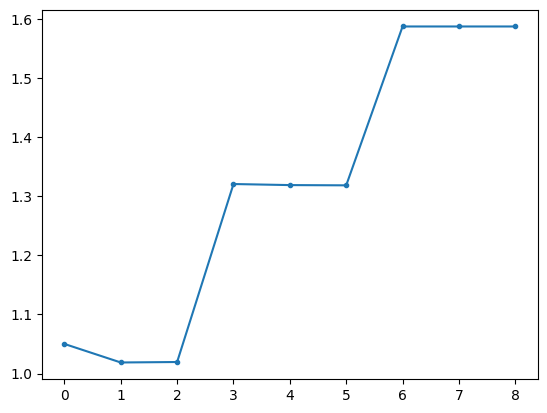

In [43]:
import matplotlib.pyplot as plt

plt.plot(rmses, marker=".")

In [47]:
lowest_rmse = min(rmses)
lowest_rmse

1.018750693475064

🪄 Based on the Root-Mean-Square Error, we could see that the change was significantly made when we change the **regParam** value. 

🪄 We also could conclude that the lowest RMSE for this dataset is 1.018750693475064

🪄 This RMSE score was achieved by the model with **regParam = 0.1** and **maxIter=10**


## 11. Generating Movie Recommendation with the Best Model

In [58]:
# Generate top 10 movie recommendations for each user
userRecs = models[1][0].recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    20|[{22, 4.098745}, ...|
|    10|[{2, 3.1143324}, ...|
|     0|[{9, 2.8032227}, ...|
|     1|[{22, 3.0840268},...|
|    21|[{52, 4.516744}, ...|
|    11|[{18, 4.753129}, ...|
|    12|[{27, 4.11771}, {...|
|    22|[{51, 4.3857274},...|
|     2|[{83, 4.848958}, ...|
|    13|[{74, 2.6432512},...|
|     3|[{51, 4.1990194},...|
|    23|[{32, 4.741954}, ...|
|     4|[{29, 3.627738}, ...|
|    24|[{52, 4.4639874},...|
|    14|[{52, 4.458726}, ...|
|     5|[{90, 4.0117207},...|
|    15|[{1, 2.6132884}, ...|
|    25|[{71, 3.0969117},...|
|    26|[{51, 4.616008}, ...|
|     6|[{25, 3.9476633},...|
+------+--------------------+
only showing top 20 rows



In [60]:
# Generate top 10 user recommendations for each movie
movieRecs = models[1][0].recommendForAllItems(10)
movieRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     20|[{17, 3.8113723},...|
|     40|[{2, 3.3311265}, ...|
|     10|[{17, 3.32023}, {...|
|     50|[{23, 3.808243}, ...|
|     80|[{3, 3.1351068}, ...|
|     70|[{4, 3.0558097}, ...|
|     60|[{22, 2.4578345},...|
|     90|[{17, 4.521472}, ...|
|     30|[{11, 4.2920747},...|
|      0|[{28, 2.6123447},...|
|     31|[{7, 2.5307412}, ...|
|     81|[{11, 3.2674375},...|
|     91|[{12, 2.952227}, ...|
|      1|[{15, 2.6132884},...|
|     41|[{4, 3.2335463}, ...|
|     61|[{8, 1.5531374}, ...|
|     51|[{26, 4.616008}, ...|
|     21|[{26, 2.8570204},...|
|     11|[{2, 3.4251788}, ...|
|     71|[{25, 3.0969117},...|
+-------+--------------------+
only showing top 20 rows



In [62]:
# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = models[1][0].recommendForUserSubset(users, 10)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    26|[{51, 4.616008}, ...|
|    19|[{22, 3.2810826},...|
|    29|[{90, 3.6386604},...|
+------+--------------------+



In [63]:
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = models[1][0].recommendForItemSubset(movies, 10)
movieSubSetRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     65|[{23, 3.9820974},...|
|     26|[{15, 2.3899853},...|
|     29|[{8, 4.859599}, {...|
+-------+--------------------+

